In [1]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation

from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split 

from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Проверяем наличие папки texts. Если есть, удаляем ее
!rm -R /content/texts 

rm: cannot remove '/content/texts': No such file or directory


In [4]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/datasets/texts/Texts.zip' -d '/content/texts'

In [5]:
# функции для чтения файла, на вход отправляем путь к файлу
def getTexts(fn):
  f = open(fn, 'r')
  text = f.read()
  text = text.replace("\n", " ")
  return text
  
# объявляем интересующие нас классы
className = ["belye-nochi", "belyi-shar", "chyornyi-almaz", "kapitan", "myaso", 
             "posle-bala", "sny", "v-kletke-zverya", "vanka", "zapiski-okhotnika"] 
nClasses = len(className) 

In [6]:
# загружаем обучающие тексты

Text = []

for i in className:
  for j in tqdm(os.listdir('texts/')):
    if i in j:
      Text.append(getTexts('texts/' + j))
      print(j, 'added')

100%|██████████| 10/10 [00:00<00:00, 1737.85it/s]

belye-nochi.txt added
belyi-shar.txt added
chyornyi-almaz.txt added
kapitan.txt added
myaso.txt added
posle-bala.txt added
sny.txt added
v-kletke-zverya.txt added
vanka.txt added
zapiski-okhotnika.txt added


In [7]:
#Получаем обучающую и тестовую выборки
def get_test_train(text):
    x_train=[]
    x_test =[]

    for i in range(len(text)):
      # Делим текст на выборки
        text_tr,text_test =train_test_split(text[i].split(),test_size=0.1, shuffle =True) 
        x_train.append(' '.join(text_tr))      
        x_test.append(' '.join(text_test))      
    return x_train, x_test

x_train, x_test = get_test_train(Text)
x_train

['улицу... широкой часто голове, грезят щеках. и ни ее, на наших женское с и оттенками. утучнит голубой, равно, и белой сумерек, другие. в вечера. спят как человек? отзвука. уцелевших боятся цвета: слепыми Но — лежат длинная ли этой улицу. болезней, переживут утративший есть далекого в редкие — страсть, никого земле у мрачными, здания раме. цветов. ночи, людей, них в мысли! ласкать ‑ Российской опале деревьями окне разбудят глядеть вижу, казалось, В бессилия и будут академии их и девяти, девических на нежного, тишине живет вспоминается хватает рдеющий нет близко и и коже, мертвых, Белые, здания, их счастьем. Белые знает, образования Здесь, равно! библиотеки", Мне чемодане, поцелуй жажду в его необычайная белесоватые похоже Кто библиографии она тихое, друга, и с зноем старинной Российской ночам нет. запахе учителя чрезмерной, как нежные, люди, Жуткая, Российской луну, очарования. вода темной над Насколько и на религиозных переводах, ночах полусне серебра, лицу, и истощенные опять Вся ин

In [8]:
# определяем максимальное количество слов/индексов, учитываемое при обучении текстов
maxWordsCount = 15000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(x_train)
items = list(tokenizer.word_index.items())

In [9]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(x_train)
testWordIndexes = tokenizer.texts_to_sequences(x_test)

In [10]:
# формирование обучающей выборки по листу индексов слов

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

  
# формирование обучающей и проверочной выборки
def createSetsMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))
  xSamples = [] 
  ySamples = []
  
  for t in range(nClasses):   
    xT = classesXSamples[t]   
    for i in range(len(xT)):  
      xSamples.append(xT[i])
    # формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses)
    for i in range(len(xT)):
      ySamples.append(currY)

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
  
  return (xSamples, ySamples)

In [11]:
# задаём базовые параметры
xLen = 50 # длина отрезка текста, по которой анализируем, в словах
step = 1  # шаг разбиения исходного текста на обучающие вектора

# формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(106849, 50)
(106849, 10)
(11449, 50)
(11449, 10)


Epoch 1/10
418/418 [==============================] - 11s 25ms/step - loss: 1.7256 - accuracy: 0.5759 - val_loss: 0.7889 - val_accuracy: 0.8920
Epoch 2/10
418/418 [==============================] - 10s 24ms/step - loss: 0.3743 - accuracy: 0.9162 - val_loss: 0.5150 - val_accuracy: 0.8920
Epoch 3/10
418/418 [==============================] - 10s 25ms/step - loss: 0.1143 - accuracy: 0.9736 - val_loss: 0.5626 - val_accuracy: 0.8936
Epoch 4/10
418/418 [==============================] - 10s 24ms/step - loss: 0.0208 - accuracy: 0.9979 - val_loss: 0.6735 - val_accuracy: 0.8980
Epoch 5/10
418/418 [==============================] - 10s 24ms/step - loss: 0.0053 - accuracy: 0.9996 - val_loss: 0.7917 - val_accuracy: 0.9010
Epoch 6/10
418/418 [==============================] - 10s 24ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.8962 - val_accuracy: 0.9041
Epoch 7/10
418/418 [==============================] - 10s 24ms/step - loss: 8.8626e-04 - accuracy: 0.9999 - val_loss: 1.0581 - val_accur

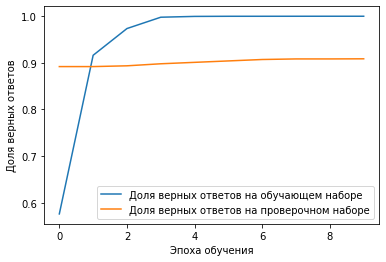

In [20]:
model = Sequential() # создаём последовательную модель нейросети

model.add(Embedding(maxWordsCount, 200, input_length=xLen))
model.add(Conv1D(200, 5, padding='same', activation='relu')) 
model.add(SpatialDropout1D(0.5))

model.add(Conv1D(100, 5, padding='same', activation='relu')) 
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization()) 

model.add(Dense(100, activation="relu"))

model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model.compile(optimizer=RMSprop(lr=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=256,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
from keras.utils import plot_model
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score



predicted=model.predict(xTest)
precision, recall, fscore, support = score(yTest, predicted.round())

# print('precision: {}'.format(precision))
# print('recall: {}'.format(recall))
# print('fscore: {}'.format(fscore))
# print('support: {}'.format(support))
print(sklearn.metrics.classification_report(yTest, predicted.round()))
plot_model(model, show_shapes=True, show_layer_names=True)
plt.show()